In [1]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [2]:
fuzzers = ['zest', 'bedivfuzz']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'imageio', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 20
timeout = 180

results_base_dir = 'eval-fast'

In [3]:
def trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject

    return df[['fuzzer', 'subject', 'trial', 'time', 'b0', 'b1', 'b2']]

In [4]:
dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    dfs.append(trial_df(fuzzer=f, subject=s, trial=t))
trials = pd.concat(dfs)

In [6]:
trials.head()

,fuzzer,subject,trial,time,b0,b1,b2
0,zest,ant,1,1,0.0,0.00,0.00
20,zest,ant,1,2,4716.0,3910.20,3871.43
40,zest,ant,1,3,9338.0,4318.14,4052.34
60,zest,ant,1,4,9886.0,4780.61,4332.42
80,zest,ant,1,5,9922.0,5037.12,4521.38


In [7]:
mean_trials = trials.groupby(['fuzzer', 'subject', 'time']).agg('mean')

In [8]:
mean_trials

trial        b0         b1         b2
fuzzer    subject time                                       
bedivfuzz ant     1      10.5    945.50   945.5000   945.5000
                  2      10.5   6559.05  3939.2605  3893.7210
                  3      10.5   9751.90  4387.9200  4116.2735
                  4      10.5  10198.70  4800.5710  4383.8610
                  5      10.5  10298.75  5077.5795  4596.3505
...                       ...       ...        ...        ...
zest      tomcat  176    10.5   9314.70  6237.2900  6054.6425
                  177    10.5   9315.10  6237.3035  6054.6620
                  178    10.5   9315.10  6237.4440  6054.8135
                  179    10.5   9315.10  6237.9665  6055.2850
                  180    10.5   9315.25  6238.0010  6055.3705

[3600 rows x 4 columns]

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



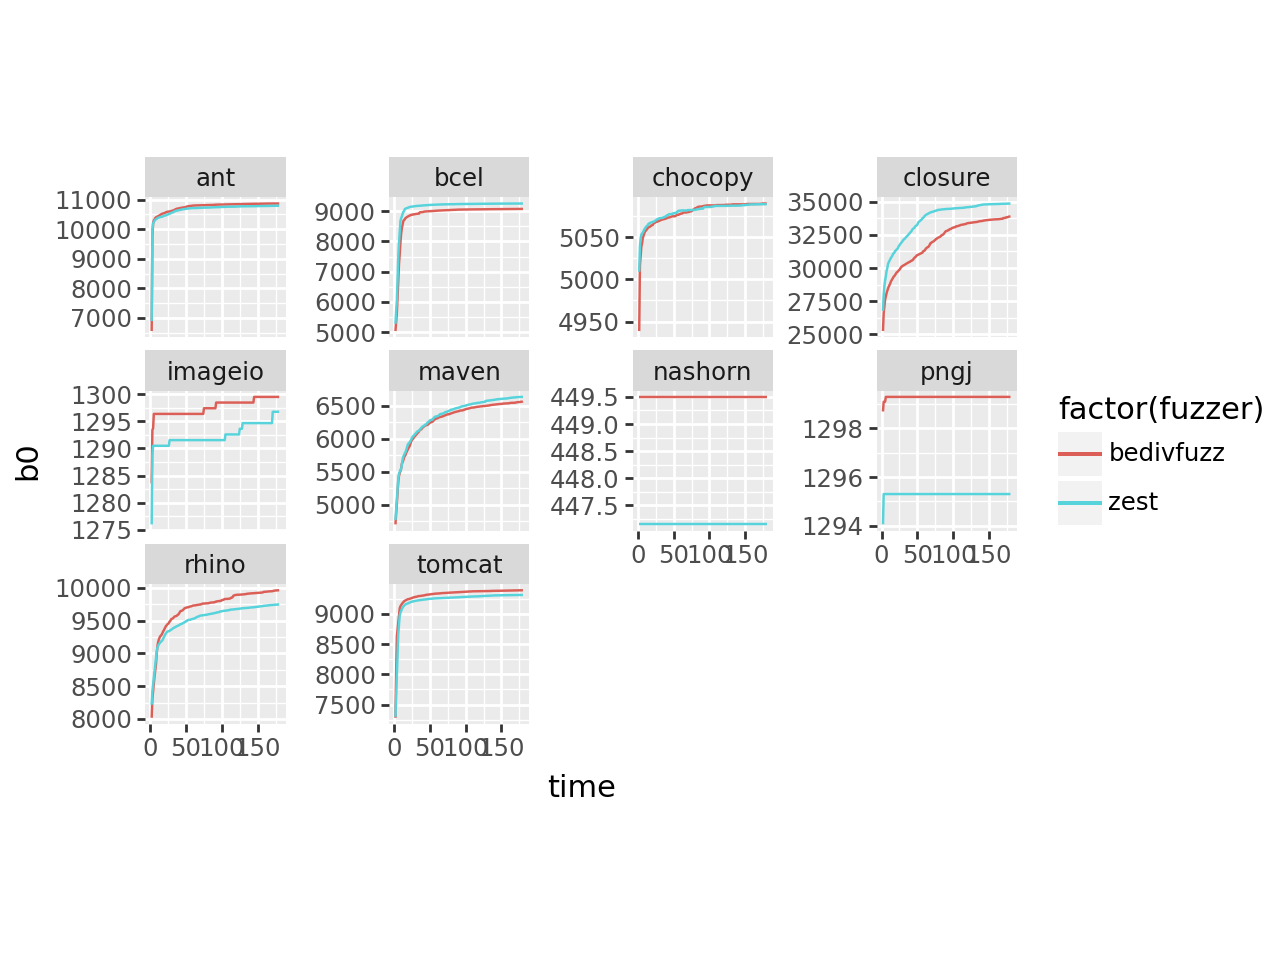

In [53]:
(ggplot(mean_trials.reset_index().query("time > 1"), aes("time", "b0", color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
)

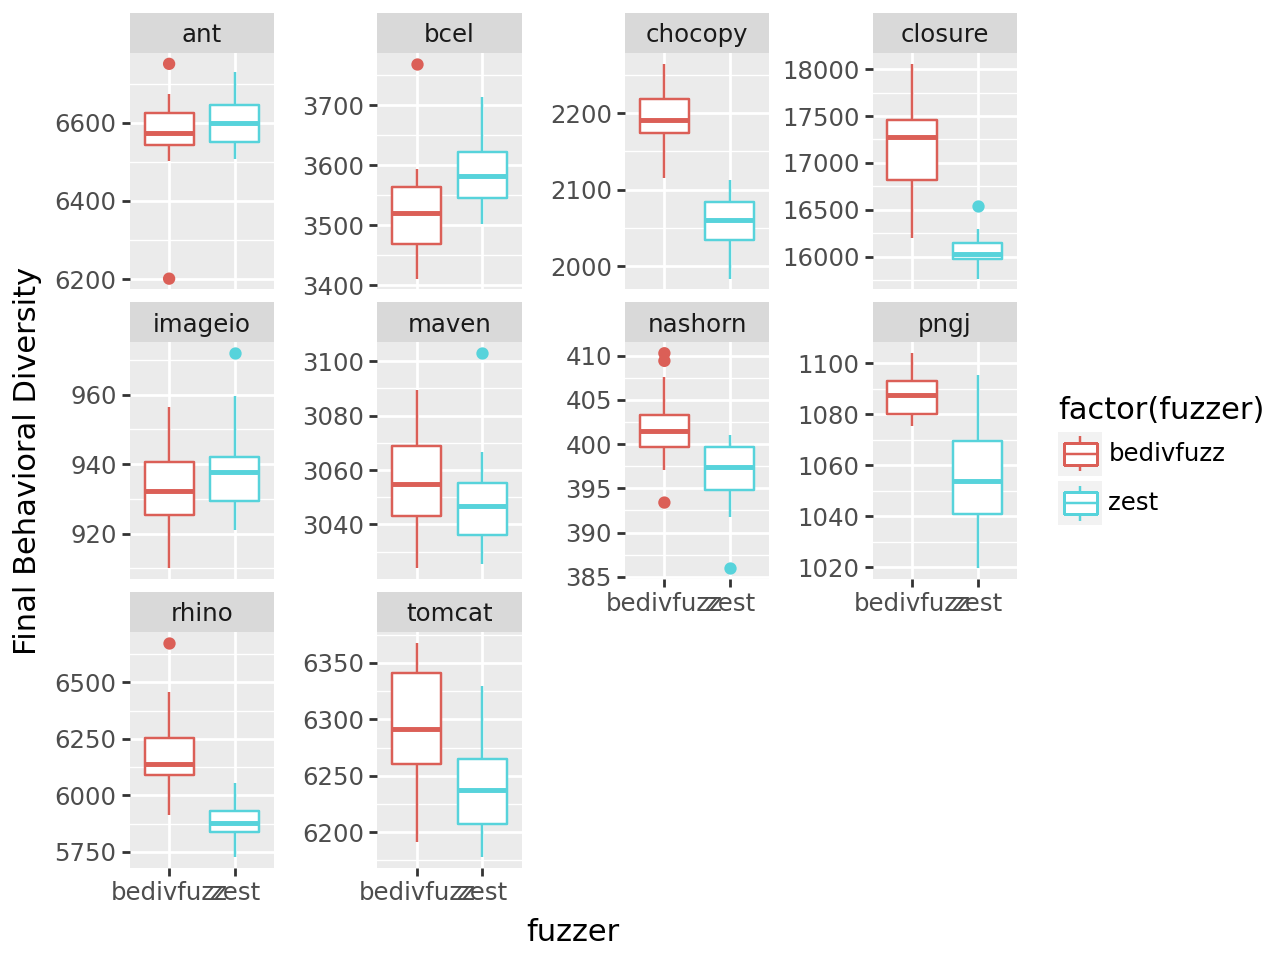

In [63]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b1", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [31]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,b0,b1,b2
3585,zest,ant,1,180,10410.0,6693.30,6397.44
3585,zest,ant,2,180,10400.0,6730.58,6511.89
3586,zest,ant,3,180,10384.0,6550.98,6260.45
3586,zest,ant,4,180,10385.0,6506.47,6207.19
3566,zest,ant,5,180,11001.0,6554.19,6261.28
...,...,...,...,...,...,...,...
3605,bedivfuzz,tomcat,16,180,9396.0,6286.57,6085.37
3606,bedivfuzz,tomcat,17,180,9380.0,6301.22,6106.43
3603,bedivfuzz,tomcat,18,180,9406.0,6352.68,6146.13
3602,bedivfuzz,tomcat,19,180,9342.0,6344.74,6150.90


In [41]:
import scipy.stats as stats

In [44]:
stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < 0.01

False

In [68]:
metric = 'b1'
alpha = 0.01
time = 30
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
imageio   : not significant
maven     : not significant
nashorn   : bedivfuzz
pngj      : bedivfuzz
rhino     : bedivfuzz
tomcat    : bedivfuzz


In [69]:
df = pd.read_csv(
        os.path.join(results_base_dir, 'bedivfuzz', 'closure', f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

In [70]:
df.head()

,# ttd,exception_class,stack_hash,coverage_hash,top5_stack_trace
0,10072,class java.lang.NullPointerException,71421181,-1491592913,com.google.common.base.Preconditions.checkNotN...
1,19216,class java.lang.NullPointerException,71421181,-2066030826,com.google.common.base.Preconditions.checkNotN...
2,36072,class java.lang.NullPointerException,71421181,-1973297493,com.google.common.base.Preconditions.checkNotN...
3,59976,class java.lang.NullPointerException,71421181,-1952081117,com.google.common.base.Preconditions.checkNotN...
4,61079,class java.lang.NullPointerException,71421181,-562376470,com.google.common.base.Preconditions.checkNotN...


In [122]:
crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [125]:
df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

In [126]:
df.head()

,# ttd,exception_class,stack_hash,coverage_hash,top5_stack_trace,crash_id
0,10072,class java.lang.NullPointerException,71421181,-1491592913,com.google.common.base.Preconditions.checkNotN...,0
1,19216,class java.lang.NullPointerException,71421181,-2066030826,com.google.common.base.Preconditions.checkNotN...,0
2,36072,class java.lang.NullPointerException,71421181,-1973297493,com.google.common.base.Preconditions.checkNotN...,0
3,59976,class java.lang.NullPointerException,71421181,-1952081117,com.google.common.base.Preconditions.checkNotN...,0
4,61079,class java.lang.NullPointerException,71421181,-562376470,com.google.common.base.Preconditions.checkNotN...,0


In [138]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [143]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [166]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer   
bcel     bedivfuzz     538630
         zest          189756
closure  bedivfuzz    3594151
         zest         4026425
imageio  bedivfuzz       3185
         zest            3926
nashorn  bedivfuzz    1843034
         zest         3401595
rhino    bedivfuzz    3369860
         zest         4239509
Name: # ttd, dtype: int64

In [156]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer   
bcel     bedivfuzz    3
         zest         3
closure  bedivfuzz    3
         zest         2
imageio  bedivfuzz    9
         zest         9
nashorn  bedivfuzz    1
         zest         1
rhino    bedivfuzz    6
         zest         4
Name: crash_id, dtype: int64

In [173]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer']).agg('mean').round(0).astype(int)

subject  fuzzer   
bcel     bedivfuzz    2920349
         zest         3070312
closure  bedivfuzz    4273644
         zest         3915184
imageio  bedivfuzz       9166
         zest            5919
nashorn  bedivfuzz    1843034
         zest         3401595
rhino    bedivfuzz    3064690
         zest          101876
Name: # ttd, dtype: int64